## Inbuilt Solutions Using OpenCV 

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from skimage.transform import resize
image_left = cv2.imread("left.png")
image_right = cv2.imread("right.png")
valve = cv2.imread('valve.png')

def HOG_CV(image):
    
    winSize = (28,28)
    blockSize = (4,4)
    blockStride = (2,2)
    cellSize = (2,2)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),)
    hist = hog.compute(image,winStride,padding,locations)
    return hist

import skimage.io, skimage.color
import numpy
import matplotlib.pyplot


def HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins):
    HOG_cell_hist = numpy.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
    
            diff = numpy.abs(curr_direction - hist_bins)
            
            if curr_direction < hist_bins[0]:
                first_bin_idx = 0
                second_bin_idx = hist_bins.size-1
            elif curr_direction > hist_bins[-1]:
                first_bin_idx = hist_bins.size-1
                second_bin_idx = 0
            else:
                first_bin_idx = numpy.where(diff == numpy.min(diff))[0][0]
                temp = hist_bins[[(first_bin_idx-1)%hist_bins.size, (first_bin_idx+1)%hist_bins.size]]
                temp2 = numpy.abs(curr_direction - temp)
                res = numpy.where(temp2 == numpy.min(temp2))[0][0]
                if res == 0 and first_bin_idx != 0:
                    second_bin_idx = first_bin_idx-1
                else:
                    second_bin_idx = first_bin_idx+1
            
            first_bin_value = hist_bins[first_bin_idx]
            second_bin_value = hist_bins[second_bin_idx]
            HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + (numpy.abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
            HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + (numpy.abs(curr_direction - second_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
    return HOG_cell_hist

def my_hog(img, bins = 16):
    samples = []
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    return (mag,ang)
    hist_bins = np.linspace(np.min(mag), np.max(mag),bins)
    return HOG_cell_histogram(ang, mag, hist_bins)

In [61]:
def find_hog(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= image.astype(np.uint8)
    hist_cv = HOG_CV(image)
    return hist_cv

<Figure size 432x288 with 0 Axes>

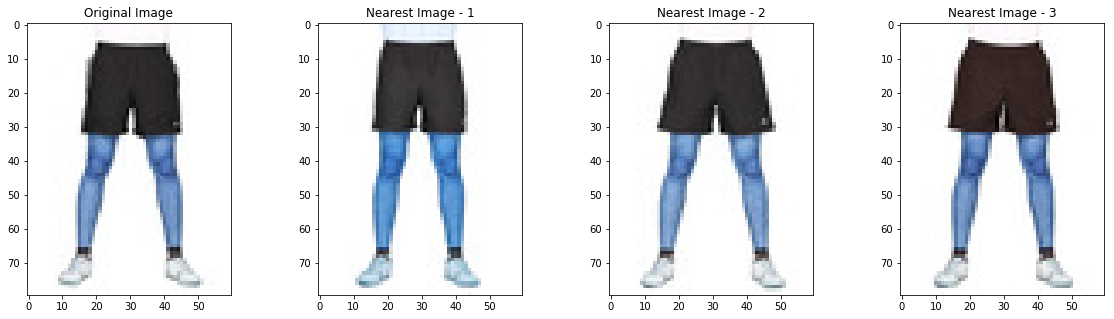

<Figure size 432x288 with 0 Axes>

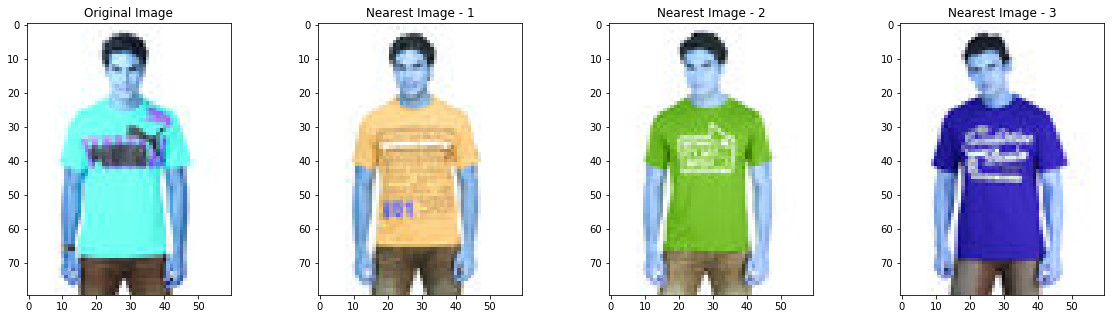

<Figure size 432x288 with 0 Axes>

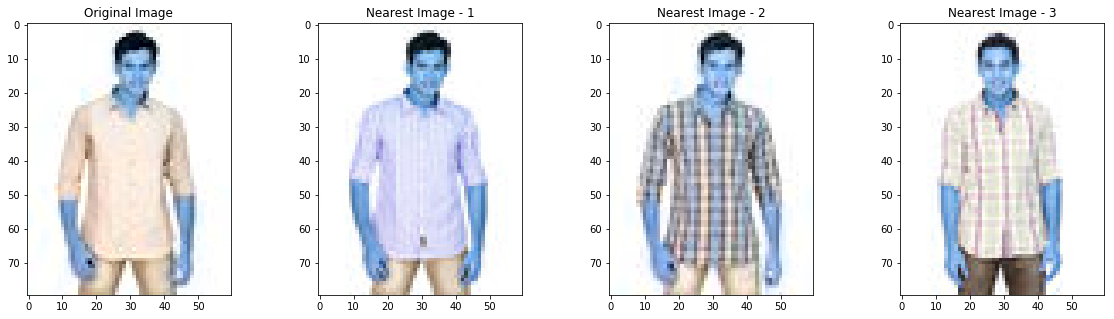

<Figure size 432x288 with 0 Axes>

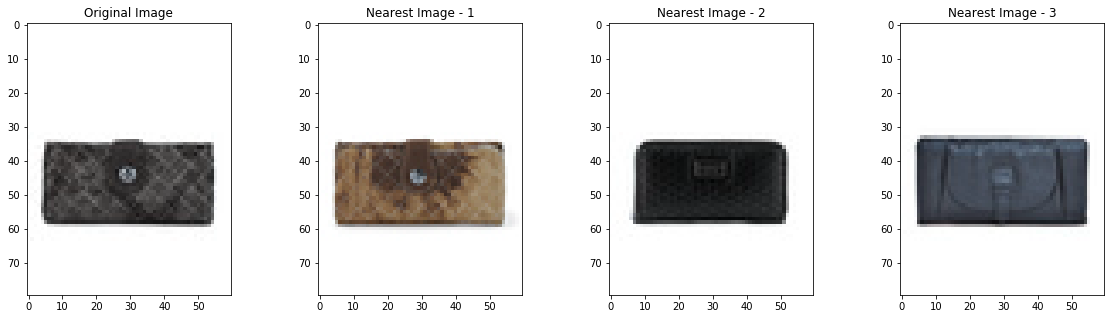

<Figure size 432x288 with 0 Axes>

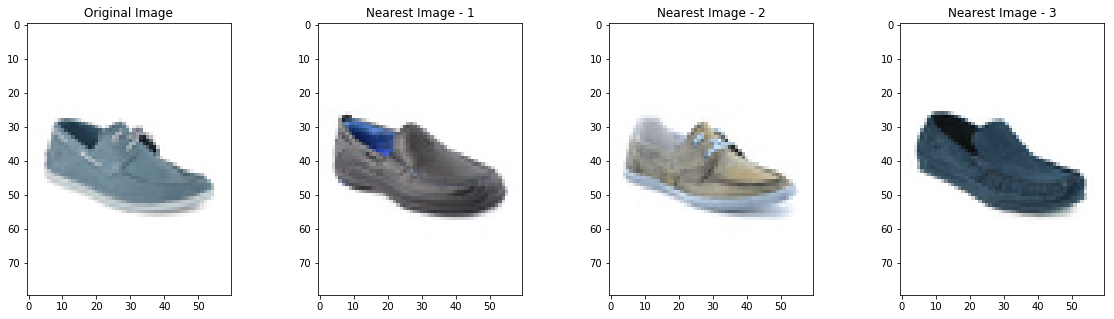

In [14]:
from sklearn.neighbors import NearestNeighbors
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from skimage.transform import resize

def HOG_CV(image):
    
    winSize = (28,28)
    blockSize = (4,4)
    blockStride = (2,2)
    cellSize = (2,2)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),)
    hist = hog.compute(image,winStride,padding,locations)
    return hist


def find_hog(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= image.astype(np.uint8)
    hist_cv = HOG_CV(image)
    return hist_cv

import glob, os
from tqdm.notebook import tqdm
#print (os.getcwd())
#os.chdir("images")
limit = 10000
dic_hog = {}
bins_list = []
for file in tqdm(glob.glob(str(os.getcwd())+"\images\*")):
    a= find_hog(cv2.imread(file))
    dic_hog[file] = [x[0] for x in a]
    bins_list.append(dic_hog[file])
    if len(bins_list) == limit:
        break
  
bins_list = np.array(bins_list)
bins_list = np.reshape(bins_list,(limit,len(bins_list[0])))
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(bins_list)


tests = ['2106.jpg','10067.jpg', '12663.jpg', '17083.jpg', '22179.jpg']

for test in tests:
    hogs = find_hog(cv2.imread(test))
    hogs = [x[0] for x in hogs]
    distances, indexes = nbrs.kneighbors([hogs])
    nearest1 =  list(dic_hog.keys())[list(indexes)[0][0]]
    nearest2 =  list(dic_hog.keys())[list(indexes)[0][1]]
    nearest3 =  list(dic_hog.keys())[list(indexes)[0][2]]
    plt.figure()
    plt.figure(figsize= (20,5))
    plt.subplot(1,4,1)
    plt.imshow(cv2.imread(test))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(cv2.imread(nearest1))
    plt.title('Nearest Image - 1')
    plt.subplot(1,4,3)
    plt.imshow(cv2.imread(nearest2))
    plt.title('Nearest Image - 2')
    plt.subplot(1,4,4)
    plt.imshow(cv2.imread(nearest3))
    plt.title('Nearest Image - 3')